# Bayesian AB Bandit

In [ ]:
import numpy as np                  
import pandas as pd
import pymc as pm       # Baysian modeling
import arviz as az      # diagnostics
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)     # reproducible randomness


we are modeling :
 booked ~ binomial(n=applicants,p)

control booking rate ~ 20%
test booking rate ~ 25%

In [ ]:
# create dataframe
data = pd.DataFrame({
    "variant": ["control", "test"],
    "applicants": [1000, 400],
    "booked": [200, 100],
})

data["rejected"] = data["applicants"] - data["booked"]
data


,variant,applicants,booked,rejected
0,control,1000,200,800
1,test,400,100,300


In [ ]:
with pm.Model() as ab_model:
    
    # Prior (weakly informative)
    p = pm.Beta("p", alpha=1, beta=1, shape=2)
    # we assume Pi ~ Beta(1,1), for control and test
    # no strong prior belief, we let data dominate
    # shape = 2 means: p[0] = control rate, p[1] = test rate

    # Likelihood
    booked = pm.Binomial(
        "booked",
        n=data["applicants"].values,
        p=p,
        observed=data["booked"].values
    )
    # bookedi ~ binomial(ni,pi)
    # given conversion rate pi, we observe number of bookings

    # Difference
    delta = pm.Deterministic("delta", p[1] - p[0])
    # we define delta = ptest-pcontrol
    # we can conmpute Probablity that delta is greater than 0 P(delta>0)
    # which is: the proability that test beats control


    trace = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        target_accept=0.95,
        random_seed=42
    )
    # this runs 4 chains
    # 2000 warmup steps
    # 2000 posterior samples
    # we now have samples from p(pcontrol,ptest | data)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


c:\anaconda\envs\pymc_env\lib\site-packages\rich\live.py:256: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 10 seconds.


In [ ]:
az.summary(trace, var_names=["p", "delta"])
# this computes mean, SD, HDI intervals, ESS, R-hat
# we are checking if chains converged to the same posterior distribution
# if R-hate ~ 1 and ESS = large - we trust the samples

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.201,0.013,0.178,0.224,0.0,0.0,4948.0,4721.0,1.0
p[1],0.251,0.021,0.212,0.291,0.0,0.0,5380.0,4951.0,1.0
delta,0.051,0.025,0.003,0.095,0.0,0.0,5476.0,4776.0,1.0


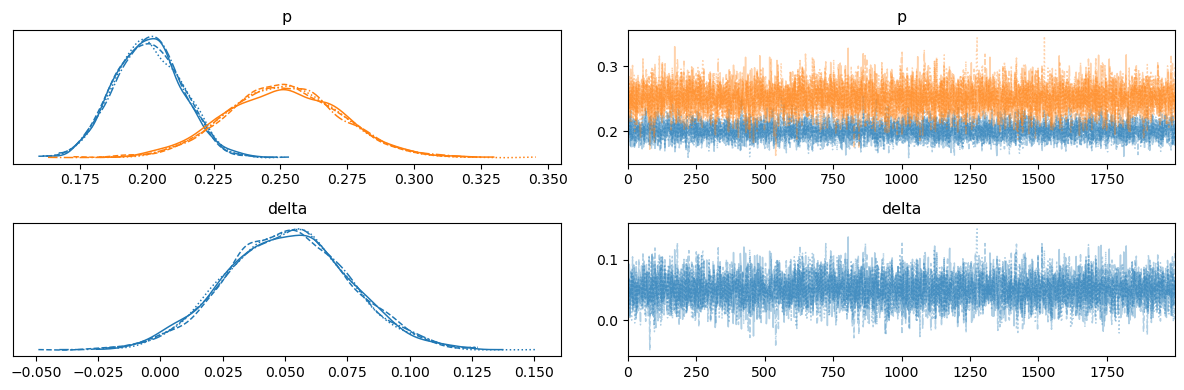

In [11]:
az.plot_trace(trace, var_names=["p", "delta"])
plt.tight_layout()
plt.show()

# trace plots
# visualizes sampling paths (trace) and posterior density
# we are checking: did chains mix well and agree?

In [13]:
delta_samples = trace.posterior["delta"].values.flatten()

prob_test_beats = np.mean(delta_samples > 0)
print(prob_test_beats)

# computes P(ptest>pcontrol)
# how many posterior samples have delta > 0
# pure Monte Carlo probability estimation

# for A/B tests 
# instead of p-values (reject/fail to reject)
# we say: there is a 97% probablity test is better

if prob_test_beats > 0.95:
    print("Ship Test")
elif prob_test_beats < 0.05:
    print("Kill Test")
else:
    print("Keep Running")


0.981875
Ship Test


In [ ]:
# turns A/B test into bandit
def thompson_allocation(trace, n_samples=10000):
    
    p_samples = trace.posterior["p"].values.reshape(-1, 2)
    #get posterior samples
    # now we have thousands of sampled (pcontrol,ptest) pairs

    draws = rng.choice(len(p_samples), size=n_samples, replace=True)
    sampled_ps = p_samples[draws]
    # randomly draw samples
    # simulate possible worlds

    winners = np.argmax(sampled_ps, axis=1)
    # pick winner per world
    # for each simulated world: which variant has higher p?

    allocation = np.bincount(winners, minlength=2) / n_samples
    # compute allocation
    # if test wins 68% of simulations and control wins 32%
    # then traffic split becomes this
    return allocation


In [9]:
allocation = thompson_allocation(trace)

pd.DataFrame({
    "variant": data["variant"],
    "traffic_share": allocation
})


,variant,traffic_share
0,control,0.0189
1,test,0.9811


In [10]:
def simulate_future_days(trace, current_data, daily_applicants=200, days=14):
    
    p_samples = trace.posterior["p"].values.reshape(-1, 2)
    
    decision_day = None
    
    for day in range(1, days+1):
        
        new_bookings = rng.binomial(daily_applicants, p_samples)
        
        updated_applicants = current_data["applicants"].values + day * daily_applicants
        updated_booked = current_data["booked"].values + new_bookings.mean(axis=0)
        
        delta = (updated_booked[1] / updated_applicants[1]) - \
                (updated_booked[0] / updated_applicants[0])
        
        if delta > 0:
            decision_day = day
            break
            
    return decision_day


In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt


In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [3]:
# ====== SCENARIO SETTINGS ======

# True conversion rates (for simulation)
true_rate_A = 0.20
true_rate_B = 0.23

# Daily applications per group
daily_apps_A = 150
daily_apps_B = 150

# Maximum days to simulate
max_days = 30

# Bayesian decision threshold
probability_threshold = 0.95


In [4]:
np.random.seed(42)

results = []

cumulative_apps_A = 0
cumulative_apps_B = 0
cumulative_bookings_A = 0
cumulative_bookings_B = 0

for day in range(1, max_days + 1):
    
    # Simulate bookings for the day
    bookings_A = np.random.binomial(daily_apps_A, true_rate_A)
    bookings_B = np.random.binomial(daily_apps_B, true_rate_B)
    
    # Update cumulative totals
    cumulative_apps_A += daily_apps_A
    cumulative_apps_B += daily_apps_B
    cumulative_bookings_A += bookings_A
    cumulative_bookings_B += bookings_B
    
    results.append({
        "day": day,
        "apps_A": cumulative_apps_A,
        "apps_B": cumulative_apps_B,
        "bookings_A": cumulative_bookings_A,
        "bookings_B": cumulative_bookings_B
    })


In [5]:
decision_day = None
prob_history = []

for r in results:
    
    with pm.Model() as model:
        
        # Priors
        p_A = pm.Beta("p_A", alpha=1, beta=1)
        p_B = pm.Beta("p_B", alpha=1, beta=1)
        
        # Likelihood
        obs_A = pm.Binomial("obs_A", 
                            n=r["apps_A"], 
                            p=p_A, 
                            observed=r["bookings_A"])
        
        obs_B = pm.Binomial("obs_B", 
                            n=r["apps_B"], 
                            p=p_B, 
                            observed=r["bookings_B"])
        
        trace = pm.sample(1000, tune=1000, chains=2, progressbar=False, cores=1, compute_convergence_checks=False)
    
    # Compute probability B > A
    p_A_samples = trace.posterior["p_A"].values.flatten()
    p_B_samples = trace.posterior["p_B"].values.flatten()
    
    prob_B_better = np.mean(p_B_samples > p_A_samples)
    prob_history.append(prob_B_better)
    
    if prob_B_better > probability_threshold and decision_day is None:
        decision_day = r["day"]


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_A, p_B]
c:\anaconda\envs\pymc_env\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 0 seconds.
c:\anaconda\envs\pymc_env\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linu

In [6]:
if decision_day:
    print(f"Decision reached on Day {decision_day}")
else:
    print("No decision reached within max_days")

print(f"Final probability B > A: {prob_history[-1]:.3f}")


Decision reached on Day 1
Final probability B > A: 1.000


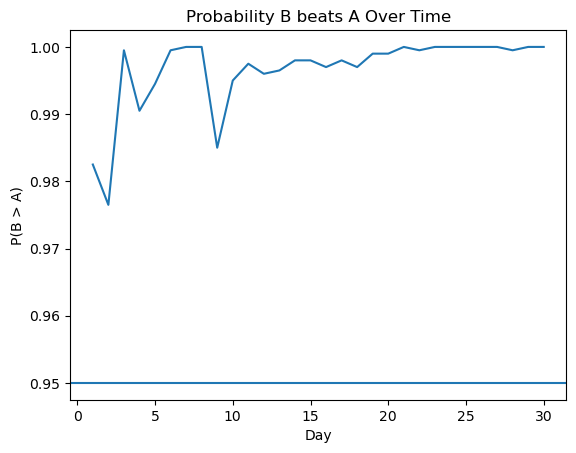

In [7]:
plt.figure()
plt.plot(range(1, max_days + 1), prob_history)
plt.axhline(probability_threshold)
plt.xlabel("Day")
plt.ylabel("P(B > A)")
plt.title("Probability B beats A Over Time")
plt.show()
